# PS4 
## Group 23

## Exercise 1
## (a)
we want to solve:<p>
$$\max_{w_i} {R_f + w_i^T (\mu - Rf 1) - 0.5\gamma^i w_i^T \Sigma w_i} =\max_{w_i}f$$
to do so:
$$\dfrac{\partial f}{\partial w_i} = \mu - R_f 1 - \gamma_i \Sigma w_i = 0 $$
We find the following solution,
$w_i = \dfrac{ \Sigma^{-1} (\mu-R_f1)}{\gamma_i} $
and so that:
$$ w_i = \dfrac{1^T * \Sigma^{-1} (\mu-R_f1)}{\gamma_i} * w_{MV} $$
The weight in the riskfree asset is therefore $ w_{0,i} = 1- 1^Tw_i $<p>
Therefore, every investor iinvest only in the risk free asset and the tangency portfolio.
## (b)
$$ \sum_{i=1}^{I}{( W_{MV}^i - W_{0,i} ) w_{MV} } = M $$
$$ \sum_{i=1}^{I}{ W_{MV}^i  w_{MV} } = MCAP_M* w_M $$
so:
$$ \sum_{i=1}^{I}{W_{MV}^i} = MCAP $$
so:
$$ w_{MV} = w_M $$		
## (c)		
$$ w_M = \sum_{i=1}^{I}{\frac{W_i}{W}w_i} = \sum_{i=1}^{I}{\frac{W_i}{W} \frac{1^T * \Sigma^{-1} (\mu-R_f1)}{\gamma_i}}$$
$$ w_M = \frac{1}{\gamma_M} \Sigma^{-1} ( \mu - R_f1) $$
$$ \sigma_M^2 = w_M^T \Sigma w_M = w_M^T *\Sigma * \Sigma^{-1} ( \mu-Rf1) * \dfrac{1}{\gamma_M} = (\mu_M - Rf) *\dfrac{1}{\gamma_M}$$
Since,$ w_M^T 1 = 1$ due to the fact that $ w_M = w_{MV}$<p>
Therefore, 
$$\mu_M = R_f + \gamma_M \sigma_M^2	 $$
We can interpret $\gamma_M$ as the risk aversion coefficient of the market as a whole.
$\dfrac{1}{\gamma_M}$ is a weighted mean of the investors' risk aversion and the weights are $ \dfrac{W_i}{W} $ for every investor, i.e. the proportion of his wealth compared to total market wealth.<p> 
## (d)
Since $	w_M = \dfrac{\Sigma^{-1} (\mu-Rf1)}{\gamma_M}$ then $\mu-R_f1 = \gamma_M \Sigma w_M $<p>
Taking the n-component:
$$ \mu_n - R_f = \gamma_M * (\Sigma w_M)_n$$
$$ (\Sigma w_M)_n = \sum_{j=1}^{N}{cov(R_n,R_j) w_{M,j}} = cov(R_n, \sum_{j=1}^{N}{w_{M,j}R_j}) = cov(R_n, R_M) $$
$$ \mu_n - R_f = \frac{\mu_M - R_f }{\sigma_M^2} cov(R_n,R_M) = \beta_n (\mu_M - R_f) $$
We could empirically test this relation through an OLS regression of the excess return of the risky asset n on the excess return of the market. The return of the market could be approximated by an index.
Then, if CAPM holds, $\alpha$ should be not significantly different from 0.

In [1]:
import wrds
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import data
db=wrds.Connection(wrds_username='matteo_ferrazzi')
sns.set(rc={'figure.figsize':(15,8)})
#import dataset
market = db.raw_sql("select date,vwretd from crsp.msi where date>='1928-01-01'and date<='2004-12-31'",date_cols=['date'])
risfe = db.raw_sql("select mcaldt, tmytm from crsp.tfz_mth_rf where kytreasnox = 2000001 and mcaldt>='1928-01-01' and mcaldt<='2004-12-31'", date_cols=["mcaldt"])
stocks = db.raw_sql(" select a.permno, a.date, b.shrcd, b.exchcd, a.ret, a.shrout, a.prc from crsp.msf as a left join crsp.msenames as b on a.permno=b.permno and b.namedt<=a.date and a.date<=b. nameendt where a.date between '01/01/1928' and '12/31/2004' and b.exchcd between 1 and 2 and b.shrcd between 10 and 11", date_cols=['date'])


Loading library list...
Done


## Exercise 2
## (a)

In [2]:
#merge rf and mkt
risfe["rf"]=risfe["tmytm"]/100
stocks["ret"]=stocks["ret"]*12
market["vwretd"]=market["vwretd"]*12

In [3]:
data = pd.merge(stocks,market, how="left", on="date")
data = pd.merge(data,risfe, how="left", left_on="date", right_on="mcaldt")
#remove nans
data["excess"] = data["ret"] - (data["rf"])
data["exc_mkt"]= data["vwretd"]- data["rf"]
data = data.dropna(subset=['excess','exc_mkt'])
data["const"] = 1

In [4]:
# we remove stocks with less than 20 observation
count_freq=dict(data['permno'].value_counts())
data['count_freq']=data['permno']
data['count_freq']=data['count_freq'].map(count_freq)
data=data[data.count_freq>60]


In [5]:
#regression
parame = data.groupby("permno").apply(lambda x:sm.OLS(x['excess'], x[['const','exc_mkt']]).fit().params).reset_index()
#rename columns
parame = parame.rename(columns={'exc_mkt': 'beta', 'const':'alpha'})
#parame = parame.dropna(subset=['alpha','beta']).copy()
#Beta shrinkage
parame["beta_s"] = (2/3) * parame["beta"] +1/3

In [6]:
# fraction of systematic risk
rsq = data.groupby("permno").apply(lambda x:sm.OLS(x['excess'], x[['const','exc_mkt']]).fit().rsquared).reset_index()
rsq = rsq.rename(columns={0 : "rsquared"})

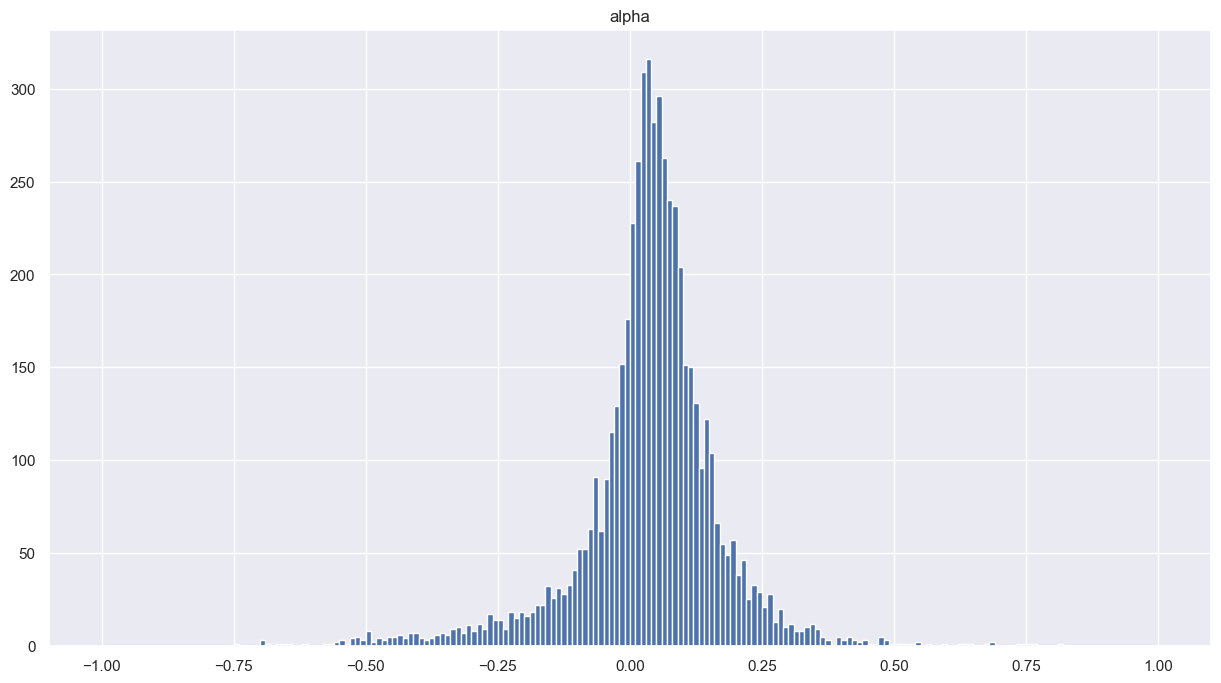

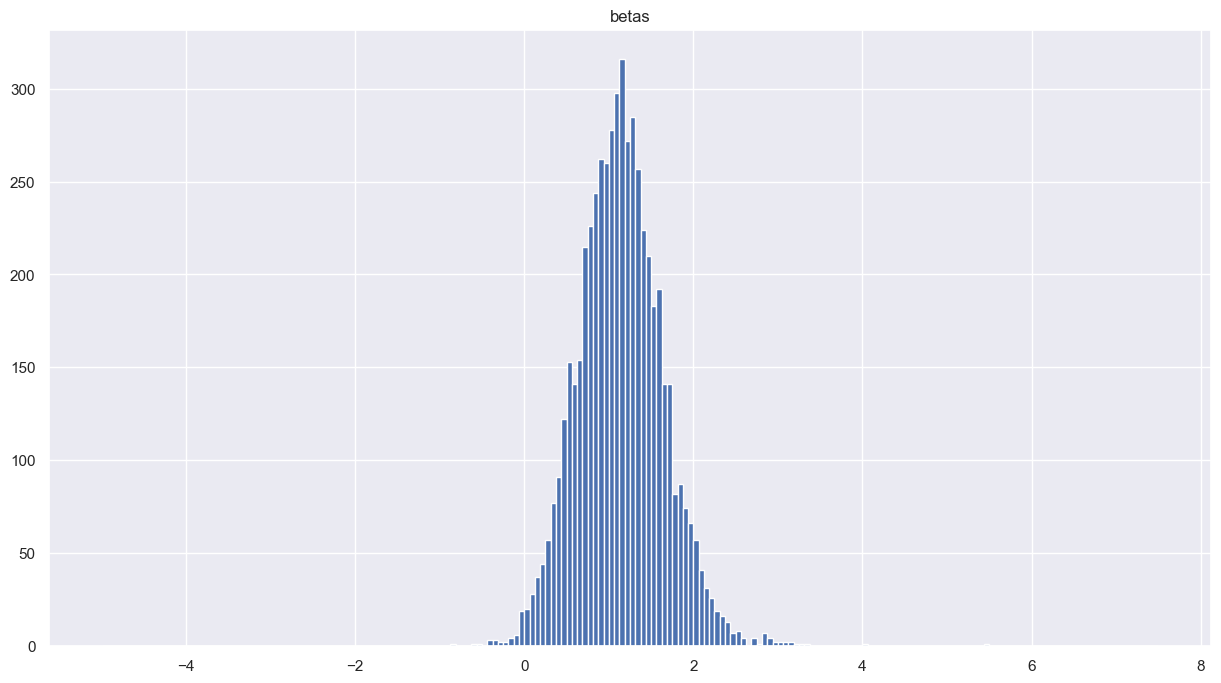

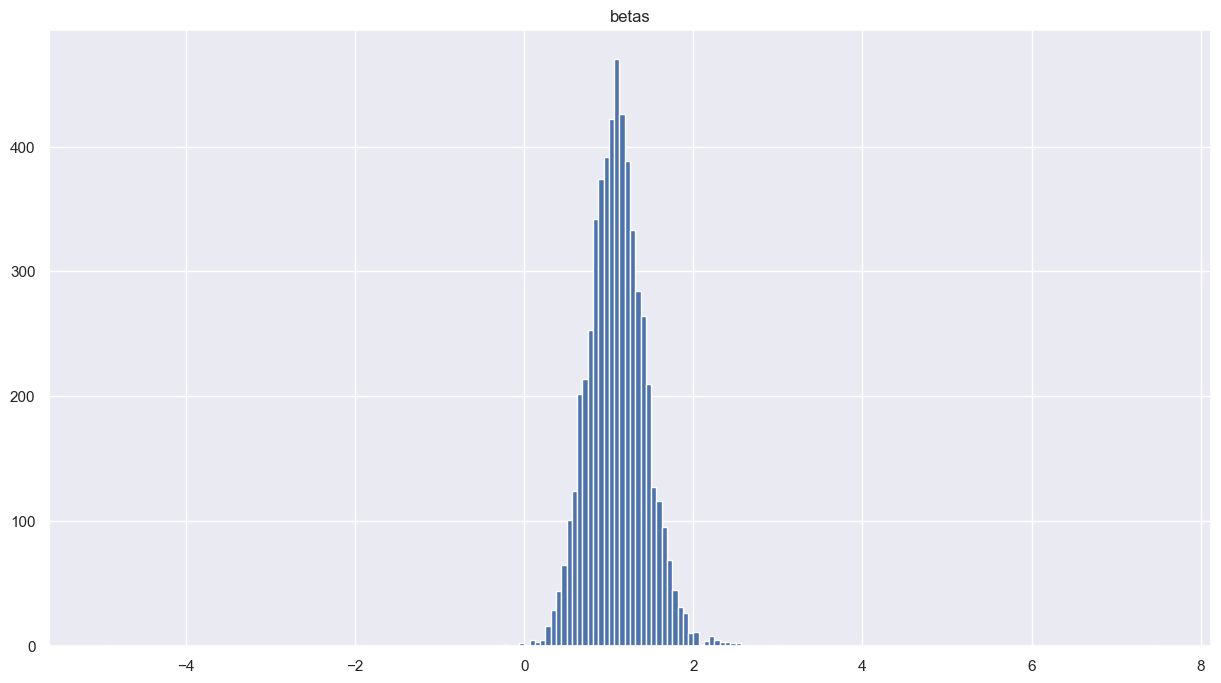

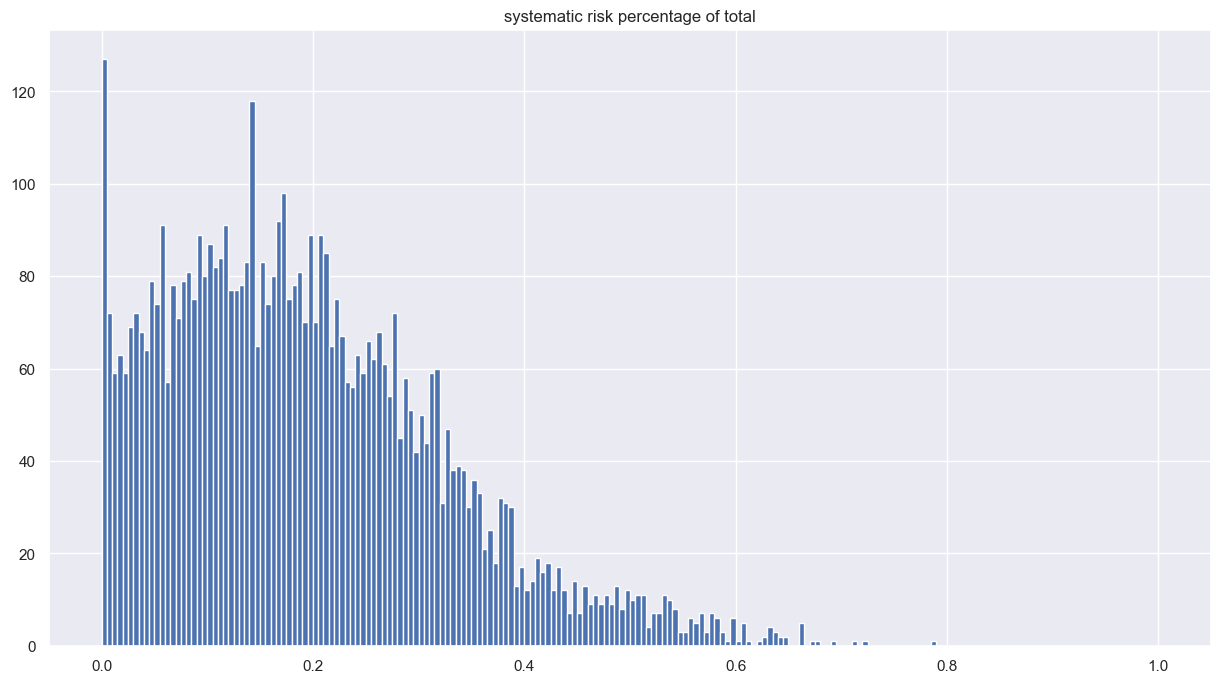

In [7]:
#plots
plt.hist(parame.alpha, bins=200, range=[-1,1])
plt.title("alpha")
plt.show()

plt.hist(parame.beta, bins=200, range=[-5,7.5])
plt.title("betas")
plt.show()

plt.hist(parame.beta_s, bins=200, range=[-5,7.5])
plt.title("betas")
plt.show()

plt.hist(rsq.rsquared, bins=200, range=[0,1])
plt.title("systematic risk percentage of total")
plt.show()

Aplhas according to the CAPM should be zero. On the other hand, we see that the true alphas are not always zero and in addition their distribution is centered in a value greater than zero. Therefore, it seems that empirically many stocks outperform the market. <p>
According to theory, betas seem to be centered in 1. This is because market beta is 1 and estimated betas revert towards market beta.<p>
Shrinkage estiamtors of beta have a more narrow distribution since these estimators are closer to 1.<p>
R_squared of the regression measures the fraction of total risk that is systematic. Therefore, 1-R_squared is the fraction of total risk that is idiosyncratic. We can deduce that the majority of stocks have an higher fraction of their variance represented by idiosyncratic risk. For some stocks the whole variance is idiosyncratic   



## (b)

In [8]:
#sort all stocks in 10 portfolio for each month
labels = ["1st", "2nd", "3rd", "4th", "5th", "6th", "7th", "8th", "9th", "10th"]
quants = pd.qcut(parame.beta, q=10, labels=labels)
quants_df = pd.DataFrame(
    {'permno': parame["permno"],
    'quantile': quants,
    })
#let's merge with original data
data = pd.merge(data,quants_df, how="left", on="permno")


In [9]:
# we add a column with the market cap of each stock 
data["w"] = data["shrout"] * np.abs(data["prc"])
# we computed the total market cap for each quantile and add a column with the weight of each stock
total = data.groupby(["date", "quantile"]).apply(lambda x : np.sum(x["w"]))
weightss = pd.DataFrame({'total': total})
data=data.set_index(['date','quantile'])
data = pd.merge(data, weightss, left_index=True, right_index=True)
data["weights"] = data["w"]/data["total"]

In [10]:
data=data.set_index('permno',append=True)

In [11]:
# we shift the weights
shifted_weights=data.groupby('permno').apply(lambda x: x['weights'].shift(1,fill_value=0))

In [12]:
shifted_weights=shifted_weights.droplevel([0])
data['shifted_weights']=shifted_weights.loc[data.index].values

In [13]:
# we add a column with the excess return of each quantile-portfolio
exc_port = data.groupby(["date","quantile"]).apply(lambda x: np.sum(x["excess"]*x["shifted_weights"])).reset_index()
# we created a new dataframe with excess return of portfolios and excess market return
exc = pd.merge(exc_port,market, how="left", on="date")
exc = pd.merge(exc,risfe, how="left", left_on="date", right_on="mcaldt")
exc = exc.rename(columns= {0:"e_ret"})
exc["exc_mkt"] = exc["vwretd"]-exc["rf"]
exc["const"]=1

In [14]:
# we computed the average return for each portfolio
avg_weight = exc.groupby("quantile").apply(lambda x : np.mean(x["e_ret"])).reset_index()
avg_weight = avg_weight.rename(columns={0:"mean_ret"})
avg_weight["return"] = avg_weight["mean_ret"] 


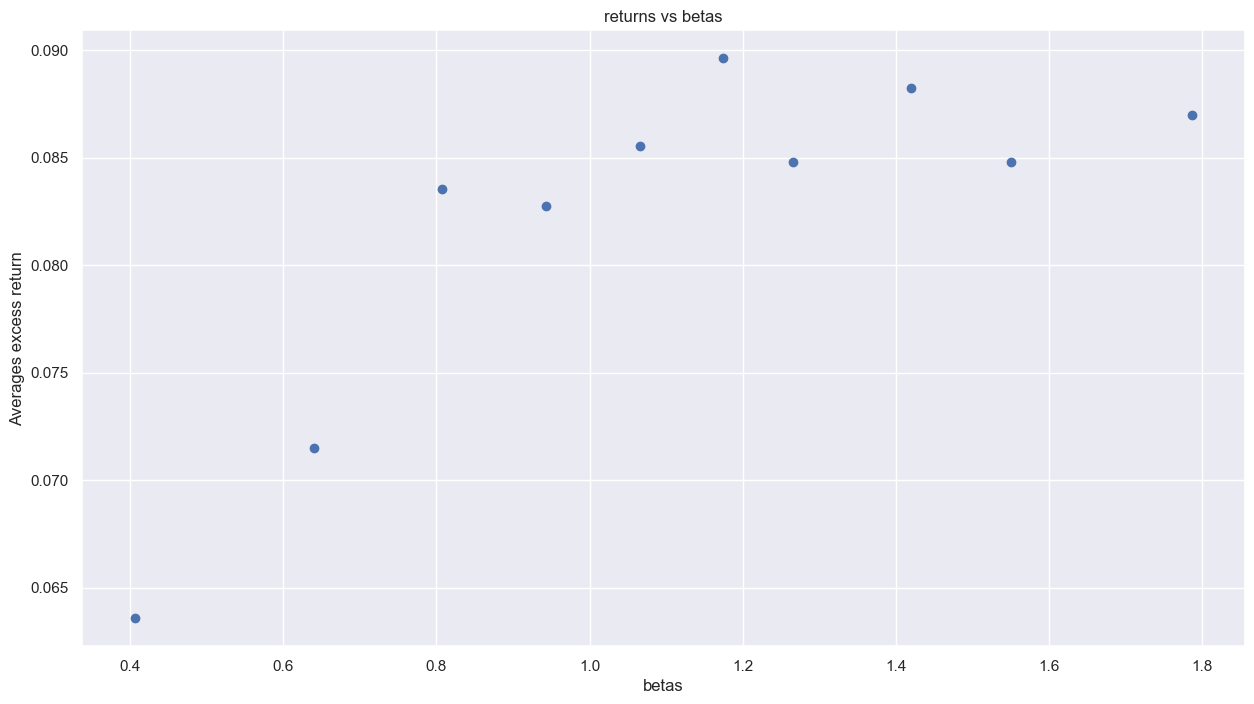

In [15]:
#compute betas
param_p = exc.groupby("quantile").apply(lambda x:sm.OLS(x['e_ret'], x[['const','exc_mkt']]).fit().params).reset_index()
param_p = param_p.rename(columns={'const': 'alpha_p', 'exc_mkt':'beta_p'})
plt.scatter(param_p["beta_p"],avg_weight["return"])
plt.title("returns vs betas")
plt.xlabel("betas")
plt.ylabel("Averages excess return")
plt.show()

In [16]:
# we created the same dataframe as before to run the regression but for equal weighted portfolio
data['total_n'] = data.groupby(["date", "quantile"]).apply(lambda x : len(x['ret']))
data['ew']=1/data["total_n"].values 

# we shift the weights
shifted_weights_e=data.groupby('permno').apply(lambda x: x['ew'].shift(1,fill_value=0))
shifted_weights_e=shifted_weights_e.droplevel([0])
data['shifted_weights_e']=shifted_weights_e.loc[data.index].values

exc_port_e = data.groupby(["date","quantile"]).apply(lambda x: np.sum(x["excess"]*x["shifted_weights_e"])).reset_index()
exc_e = pd.merge(exc_port_e,market, how="left", on="date")
exc_e = pd.merge(exc_e,risfe, how="left", left_on="date", right_on="mcaldt")
exc_e = exc_e.rename(columns= {0:"e_ret"})
exc_e["exc_mkt"] = exc_e["vwretd"]-exc_e["rf"]
exc_e["const"]=1
avg_weight_e = exc_e.groupby("quantile").apply(lambda x : np.mean(x["e_ret"])).reset_index()
avg_weight_e = avg_weight_e.rename(columns={0:"mean_ret"})
avg_weight_e["return"] = avg_weight_e["mean_ret"] 

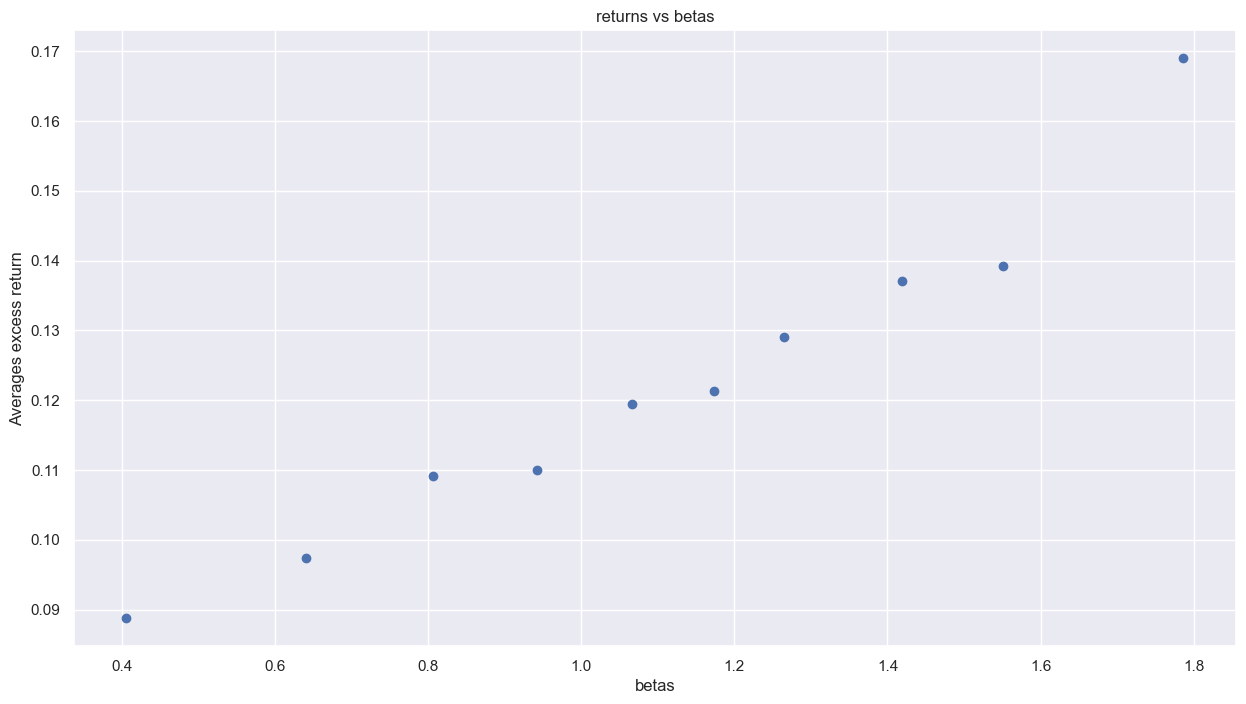

In [17]:
param_p_e = exc.groupby("quantile").apply(lambda x:sm.OLS(x['e_ret'], x[['const','exc_mkt']]).fit().params).reset_index()
param_p_e = param_p_e.rename(columns={'const': 'alpha_p_e', 'exc_mkt':'beta_p_e'})
plt.scatter(param_p_e["beta_p_e"],avg_weight_e["return"])
plt.title("returns vs betas")
plt.xlabel("betas")
plt.ylabel("Averages excess return")
plt.show()

Intuitively, we sort stocks into beta portfolio in order to decrease the volatility of the return. Doing so it is possible to better see the trend and the relationship (that according to CAPM should be linear) between the excess return and its beta. <p>
On the other hand, considering all the stocks singularly the relation should be the same but in practice we would have much more noise.

## (c)

/Users/matteoferrazzi/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


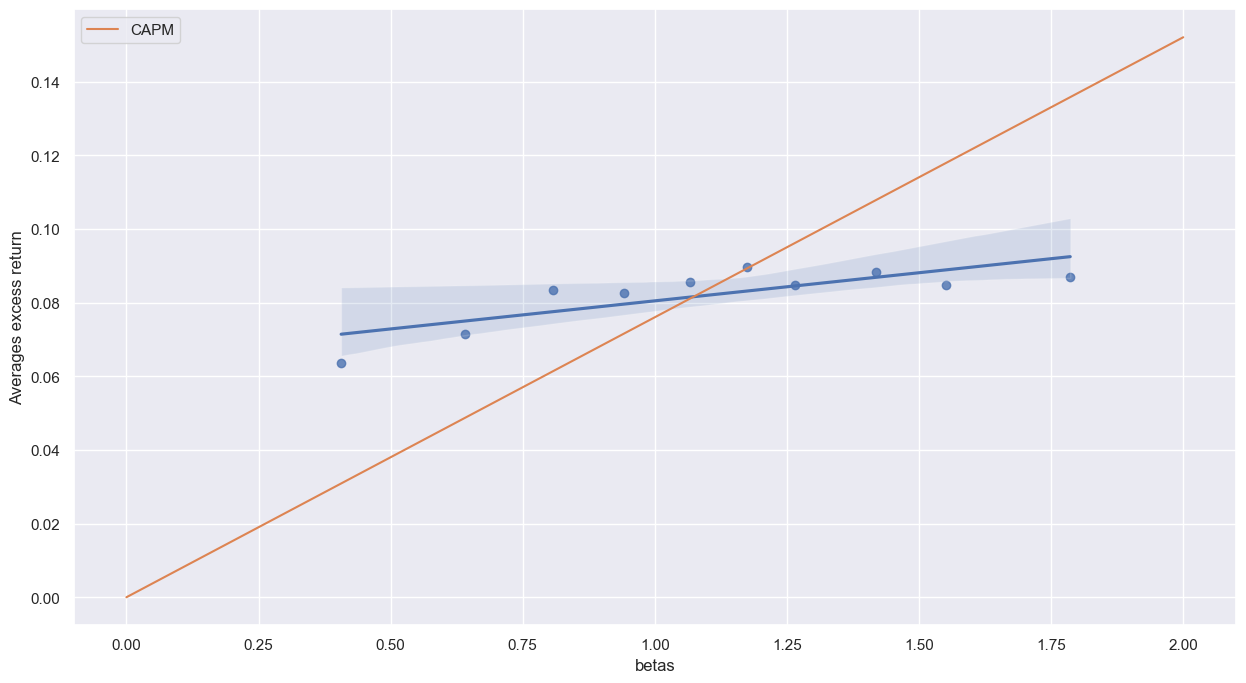

In [18]:
m_rf=np.mean(risfe["rf"])
m_m=np.mean(market["vwretd"])
sns.regplot(param_p["beta_p"],avg_weight["return"])
sns.lineplot([0,2],[0,2*(m_m-m_rf)],label='CAPM')
plt.legend()
plt.xlabel("betas")
plt.ylabel("Averages excess return")
plt.show()

/Users/matteoferrazzi/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


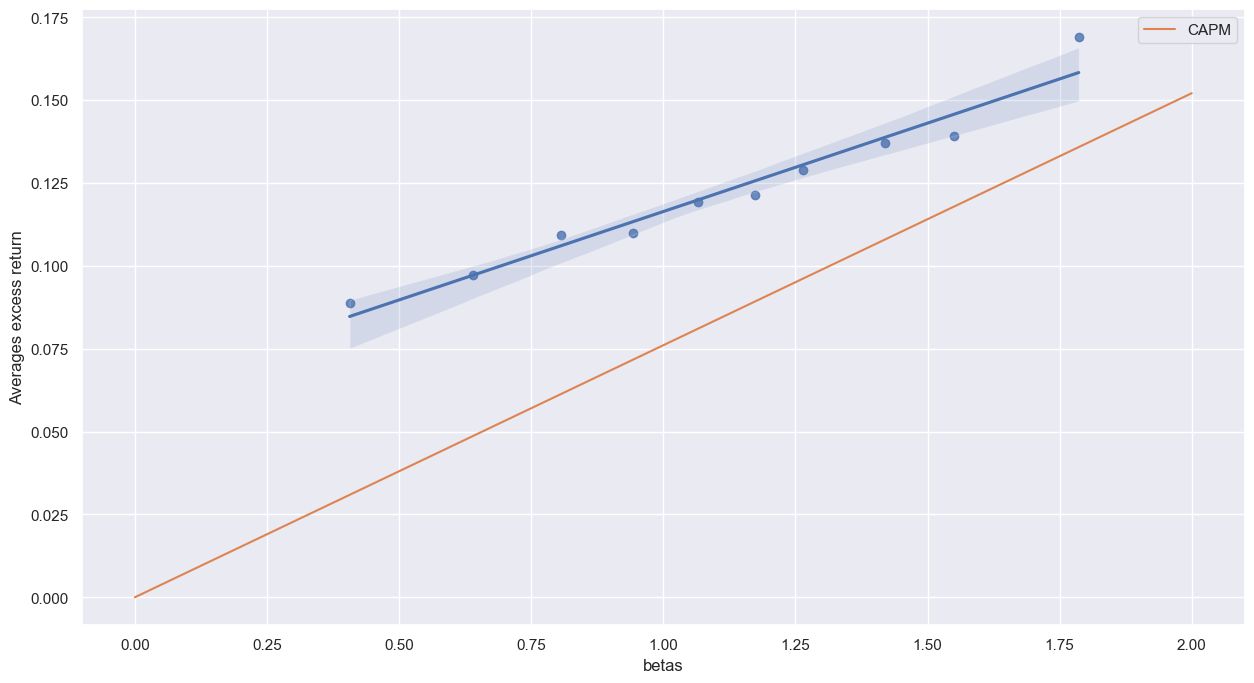

In [19]:
sns.regplot(param_p_e["beta_p_e"],avg_weight_e["return"])
sns.lineplot([0,2],[0,2*(m_m-m_rf)],label='CAPM')
plt.legend()
plt.xlabel("betas")
plt.ylabel("Averages excess return")
plt.show()

These findings seem not to be consistent with the CAPM since the theoretical slope of the CAPM line is much higher than the empirical one that we have found from the data, and this is especially true with the value weighted portfolio. Therefore, for low betas we have higher alphas.<p>
There could be different reasons for that for example: individuals have imperfect and heterogeneous informations, market portfolio in unobservable or transaction costs that prevent people from optimally rebalance their portfolio.<p>
It is possible to implement a strategy with positive alpha, starting from the mean-variance efficient of the individual and going long or short pure in alpha-bet portfolios $r_i=R_i^e-\beta_iR_M^e=\alpha_i+\epsilon_i$ that are zero cost with zero exposure. In this way we deviate from the two fund separation theorem in order put more weight in the asset i if $\alpha_i>0$ and less weight in the asset i if $\alpha_i<0$.<p>
Empirically we see that the stocks with higher $\alpha$ are the one with lower beta therefore, buying more of these stocks, shorting the risk-free, make possible to construct a strategy with a positive alpha.   
